In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import chlorophyll
import config
import absorption
import size_fraction
import scatter
import daylight
import surface_light
import light_profile

%matplotlib inline

In [2]:
wavelengths = config.wavelengths
depths = config.depths



# The Platt Sathyendranath Model (PSM)

PSM is a spectrally-resolved model that incorporates vertical structure in chlorophyll-a concentration. The model simulates changes in photosynthesis as a function of irradiance using a two-parameter photosynthesis versus irradiance (P-I) function. The main components of the models can be described as follows:

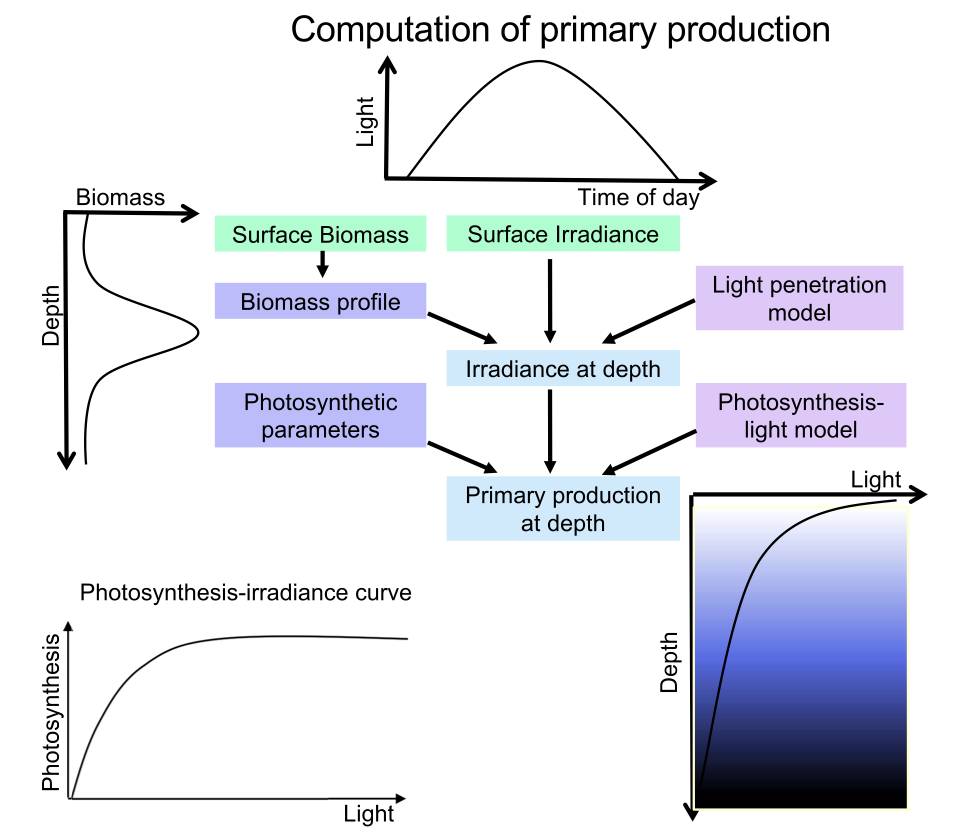


The model is described in detail in Kulk et al. 2020 (doi:10.3390/rs12050826).

## Depth-resolved Chl profile

Satellite-derived Chl is based on the integrated watermass down to about the first optical depth (10% light level), but defined as a volumetric property (mg m<sup>-3</sup>). We convert the surface estimate to a depth profile by using a shifted gaussian function:

$B(z) = B_0 + \frac{h}{\sigma*\sqrt{2\pi}} e^{-{\left( \frac{(z-z_m)^2}{2\sigma^2} \right)}}$

and

$\rho' = \left( \frac{h}{\rho \sqrt{2\pi}}\right) / \left( \left( \frac{h}{\sigma \sqrt{2\pi}} \right) + B_0 \right )$

where $B_0$ is the background biomass in mg $m^{−3}$, h the total peak biomass (mg $m^{-2}$), $z_m$ the depth of the chlorophyll maximum (m), $\sigma$ the standard deviation around the peak value (mg $m^{−3}$), and $\rho$ the ratio of the chlorophyll peak height to the total peak biomass at $z_m$. We use the following values in this exercise:

$\sigma$ =24 

$\rho$ = 0.86 

$z_m$ = 60 


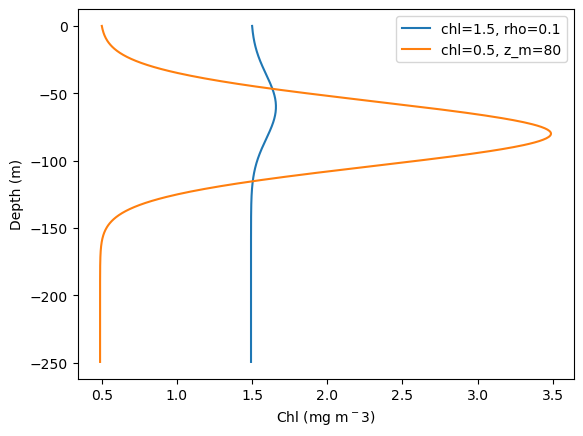

In [3]:

# chlz = chlorophyll.sinusodal_profile(chl, sigma=24, rho=0.86, z_m=60, mld=None)
chlz = chlorophyll.sinusodal_profile(1.5, rho=0.1)
plt.plot(chlz, -depths, label="chl=1.5, rho=0.1") 
chlz = chlorophyll.sinusodal_profile(0.5, z_m=80)
plt.plot(chlz, -depths, label="chl=0.5, z_m=80")
plt.xlabel("Chl (mg m${^-3}$)")
plt.ylabel("Depth (m)")
plt.legend()

## Chl size distribution
The chl profile can be divided into different size groups using the Hirata/Brewin model. 

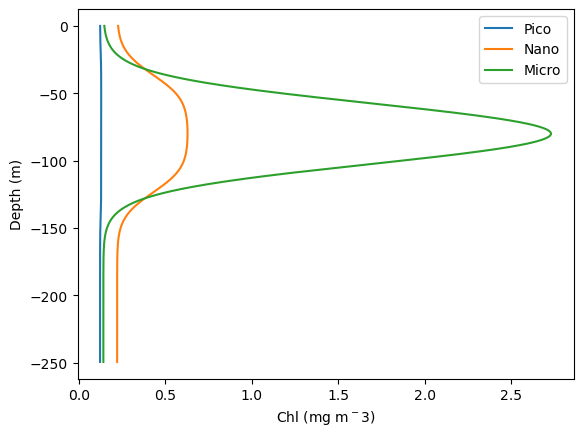

In [4]:
pico_chl, nano_chl, micro_chl = size_fraction.brewin(chlz)

plt.plot(pico_chl, -depths, label="Pico")
plt.plot(nano_chl, -depths, label="Nano")
plt.plot(micro_chl, -depths, label="Micro")
plt.xlabel("Chl (mg m${^-3}$)")
plt.ylabel("Depth (m)")
plt.legend()

## Attenuation 

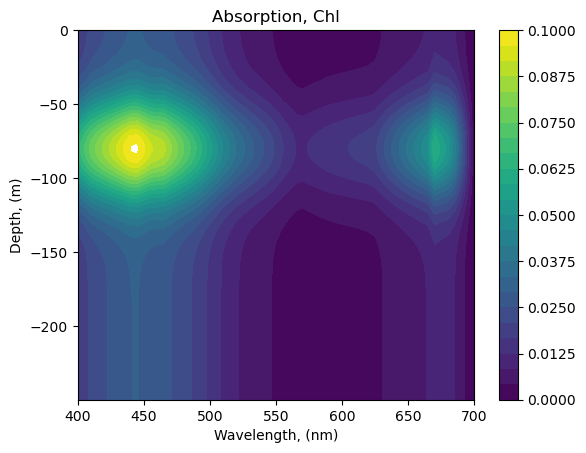

In [5]:
ac,ac_mean = absorption.calc_ac(chlz, wavelengths=wavelengths)

def pcolor(ac, title):
    plt.contourf(wavelengths, -depths, ac, np.linspace(0,0.1,25))
    plt.xlabel("Wavelength, (nm)")
    plt.ylabel("Depth, (m)")
    plt.title(title)
    plt.colorbar()

pcolor(ac,"Absorption, Chl")


In [6]:
scdict = scatter.all(wavelengths=wavelengths)

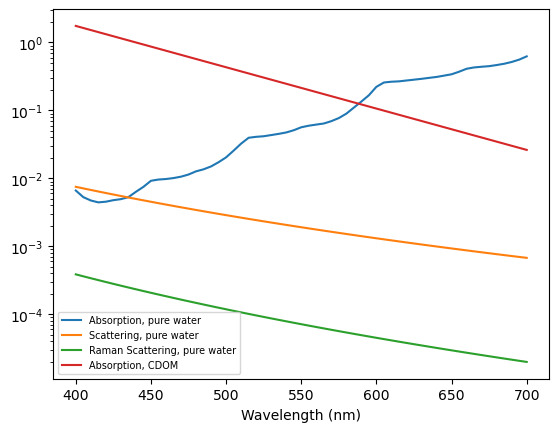

In [7]:
plt.plot(wavelengths, scdict["aw"], label="Absorption, pure water")
plt.plot(wavelengths, scdict["bw"], label="Scattering, pure water")
plt.plot(wavelengths, scdict["bbr"], label="Raman Scattering, pure water")
plt.plot(wavelengths, scdict["ay"], label="Absorption, CDOM")

plt.xlabel("Wavelength (nm)")
plt.setp(plt.gca(), yscale="log")
plt.legend(loc="lower left", fontsize=7)



## Surface light

In [8]:
dtm = pd.to_datetime("2020-05-06 12:00")
lat = 45
PAR = 25

print("Sunrise:   ", daylight.sunrise(dtm, lat))
print("daylength: ", daylight.daylength(dtm, lat))
print("Zenith:    ", np.rad2deg(daylight.zenith(dtm, lat)))
print("Diurnal range: ", daylight.time_range(dtm, lat, zenith_deg=80))


Sunrise:    2020-05-06 04:49:24
daylength:  14.282551888960276
Zenith:     28.134585829885754
Diurnal range:  DatetimeIndex([          '2020-05-06 05:49:19',
               '2020-05-06 06:56:42.818181818',
               '2020-05-06 08:04:06.636363636',
               '2020-05-06 09:11:30.454545454',
               '2020-05-06 10:18:54.272727272',
               '2020-05-06 11:26:18.090909090',
               '2020-05-06 12:33:41.909090909',
               '2020-05-06 13:41:05.727272727',
               '2020-05-06 14:48:29.545454545',
               '2020-05-06 15:55:53.363636363',
               '2020-05-06 17:03:17.181818181',
                         '2020-05-06 18:10:41'],
              dtype='datetime64[ns]', freq=None)


In [9]:
ira = surface_light.instant(dtm, lat, PAR, wavelengths=wavelengths)

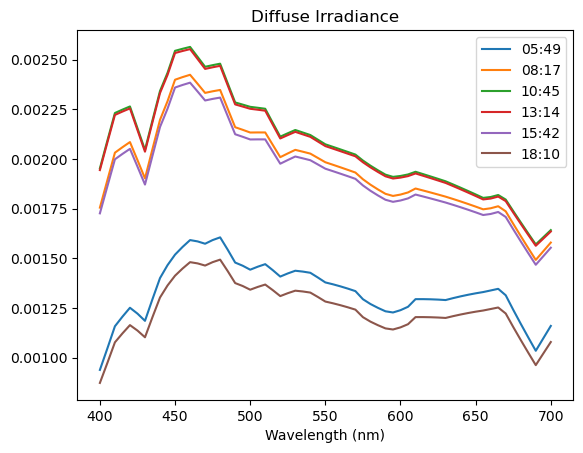

In [10]:
dtmvec = daylight.time_range(dtm, lat, zenith_deg=80, steps=6)
for dtm in dtmvec:
    ira = surface_light.instant(dtm, lat, PAR, wavelengths=wavelengths)
    plt.plot(wavelengths, ira["diffuse"], label=f"{dtm.hour:02}:{dtm.minute:02}")
plt.xlabel("Wavelength (nm)")
plt.title("Diffuse Irradiance")
plt.legend()


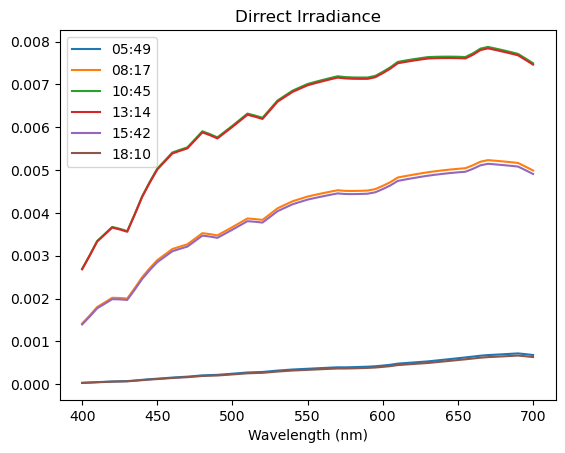

In [11]:
dtmvec = daylight.time_range(dtm, lat, zenith_deg=80, steps=6)
for dtm in dtmvec:
    ira = surface_light.instant(dtm, lat, PAR, wavelengths=wavelengths)
    plt.plot(wavelengths, ira["direct"], label=f"{dtm.hour:02}:{dtm.minute:02}")
plt.xlabel("Wavelength (nm)")
plt.title("Dirrect Irradiance")
plt.legend()


In [12]:
irw = light_profile.compute_profile(chlz, 80, ira["direct"], ira["diffuse"], wavelengths=wavelengths)

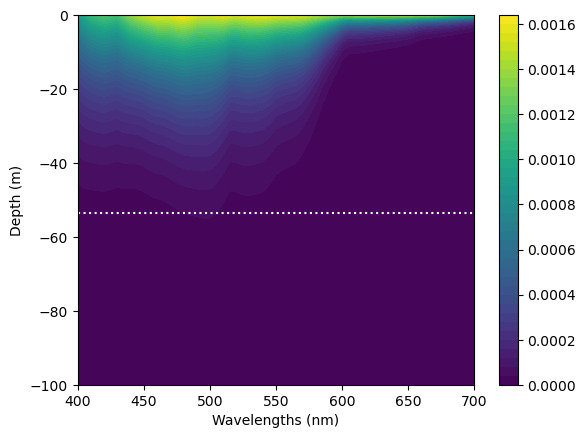

In [13]:
plt.contourf(wavelengths, -depths, irw["Iz"], 50)
plt.plot([400,700],[-irw["euphotic_depth"], -irw["euphotic_depth"]], ":", c="w")
plt.ylim(-100,0)
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Depth (m)")
plt.colorbar()

## Primary Production model

In [14]:
Pb_m = 6.0
Al_b = 0.02
lat = 45
par = 25
chlz = chlorophyll.sinusodal_profile(1.5, rho=0.1)
ac,ac_mean = absorption.calc_ac(chlz)
irs = surface_light.instant(dtm, lat, par)
irz = light_profile.compute_profile(chlz, 80, irs["direct"], irs["diffuse"])

Al_zl = Al_b * ac * 6022.0 / (2.77 * 36.0 * ac.mean(axis=1)[:,None])
I_alpha = np.sum(scdict["d_lambda"] * Al_zl * irz["Iz"] / irz["mu_d"], axis=1)
PP = chlz * Pb_m * (1 - np.exp(-I_alpha/Pb_m))


Text(0, 0.5, 'Depth')

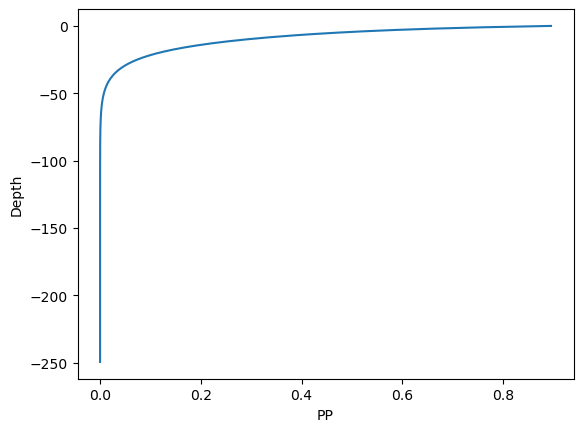

In [15]:
plt.plot(PP, -depths)
plt.xlabel("PP")
plt.ylabel("Depth")

In [16]:
dtmvec = daylight.time_range(dtm, lat, zenith_deg=80, steps=6)
PPlist = []
for dtm in dtmvec:
    irs = surface_light.instant(dtm, 60, 25)
    irz = light_profile.compute_profile(chlz, 80, irs["direct"], irs["diffuse"])
    Al_zl = Al_b * ac * 6022.0 / (2.77 * 36.0 * ac.mean(axis=1)[:,None])
    I_alpha = np.sum(scdict["d_lambda"] * Al_zl * irz["Iz"] / irz["mu_d"], axis=1)
    PPlist.append(chlz * Pb_m * (1 - np.exp(-I_alpha/Pb_m)))
PP = np.array(PPlist).T

    



Text(0, 0.5, 'Depth')

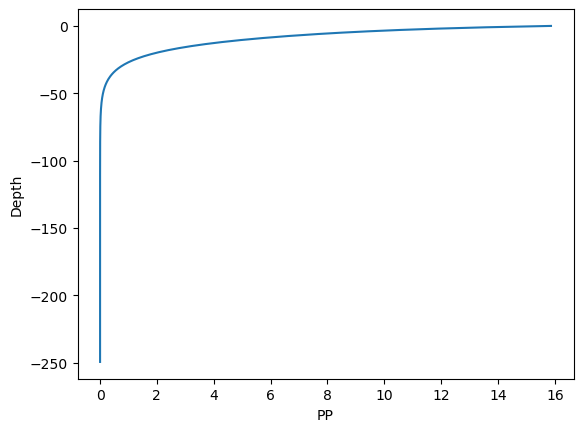

In [18]:
plt.plot(PP.sum(axis=1), -depths)
plt.xlabel("PP")
plt.ylabel("Depth")